# Filtering data based on QC parameters

Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


reading /Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS833/filtered_feature_bc_matrix.h5
 (0:00:01)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


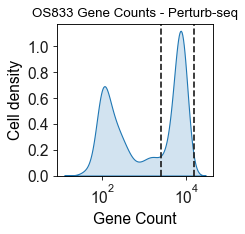

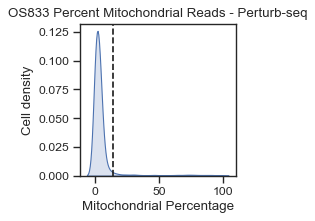

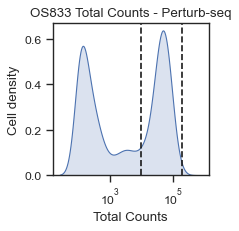

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:650: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["gene_count_corr"] = np.round(


Normalized count data: X.
Extracted 9000 highly variable genes.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
97
79
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    385 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    424 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
regressing out ['n_counts', 'pct_counts_mt', 'ccdifference']
    sparse input is densified and may lead to high memory use


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


    finished (0:00:28)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


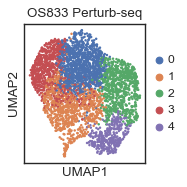

In [1]:
from svae import SpikeSlabVAE, metrics, sparse_shift, sVAE
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import anndata as AnnData
import scrublet as scr
import cellrank as cr
import seaborn as sns
import scvelo as scv
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib
import fsspec
import scvi
import h5py
import networkx
import desc 
import umap
import igraph
import h5py
import networkx
import svae
import os
sc.set_figure_params(figsize=(2.5, 2.5))
sc.settings.verbosity = 3 
%load_ext rpy2.ipython
%matplotlib inline     
np.random.seed(42)

# Reading in H5 file
# Contains the cutoff at 9k cells
adata = sc.read_10x_h5('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS833/filtered_feature_bc_matrix.h5')


# Making the var names unique
adata.var_names_make_unique()


# Filtering as is done in Seurat
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


# Computing mitochondrial percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

plt.figure()
sns.kdeplot(data=adata.obs, x='n_genes_by_counts', fill=True, alpha=0.2, log_scale=True)


# Add a vertical line at x = 20000
plt.axvline(x=15000, color='k', linestyle='--')
plt.axvline(x=2500, color='k', linestyle='--')


# Set labels and a classic theme
plt.xlabel("Gene Count")
plt.ylabel("Cell density")
sns.set_theme(style="ticks")  # Reduces gridlines
plt.title("OS833 Gene Counts - Perturb-seq")
plt.grid(False)  # Removes gridlines completely
# Save the plot
plt.savefig('/Users/brendamelano/Desktop/OS833_Gene_Counts_Perturb-seq.svg', format='svg')

plt.show()



## Percent mitochondrial reads

#This may only show up correctly after filtering
plt.figure()
sns.kdeplot(data=adata.obs, x='pct_counts_mt', fill=True, alpha=0.2)

# Add a vertical line at x = 20000
plt.axvline(x=14, color='k', linestyle='--')

# Set labels and a classic theme
plt.xlabel("Mitochondrial Percentage")
plt.ylabel("Cell density")
sns.set_theme(style="ticks")  # Reduces gridlines
plt.title("OS833 Percent Mitochondrial Reads - Perturb-seq")
plt.grid(False)  # Removes gridlines completely

# Save the plot
#plt.savefig('/Users/brendamelano/Desktop/OS833_Percent_Mitochondrial_Reads_Perturb-seq.svg', format='svg')

plt.show()

plt.figure()
sns.kdeplot(data=adata.obs, x='total_counts', fill=True, alpha=0.2, log_scale=True)

# Add a vertical line at x = 20000
plt.axvline(x=10000, color='k', linestyle='--')
plt.axvline(x=200000, color='k', linestyle='--')

# Set labels and a classic theme
plt.xlabel("Total Counts")
plt.ylabel("Cell density")

sns.set_theme(style="ticks")  # Reduces gridlines
plt.title("OS833 Total Counts - Perturb-seq")
plt.grid(False)  # Removes gridlines completely

# Save the plot
#plt.savefig('/Users/brendamelano/Desktop/OS833_Total_Counts_Perturb-seq.svg', format='svg')


plt.show()


# for hard cutoff
# Filtering the adata set based on total counts, genes and mitochondrial percentage
adata = adata[(adata.obs['total_counts'] >= 10000) &
                        (adata.obs['total_counts'] <= 200000) &
                        (adata.obs['n_genes_by_counts'] >= 2500) &
                        (adata.obs['n_genes_by_counts'] < 15000) & 
                        (adata.obs['pct_counts_mt'] < 14)
                        ]


# weren't the samples filtered in seurat? check which additional cells and genes are filtered out here
#scv.pp.filter_genes(adata, min_shared_counts=20)


# normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)


# filtering the dataset to only keep the most variable genes
# this is redundant to selecting highly variable genes
scv.pp.filter_genes_dispersion(adata, n_top_genes=9000)
# previously at 1500

# make sure that the log transformation is where it belongs in this preprocessing sequence
scv.pp.log1p(adata)

# making the adata copy below might have to go before the log transformation


# preserving the counts
adata.layers["counts"] = adata.X.copy() 


# freezing the data in raw
adata.raw = adata


# creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# Selecting highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=9000, 
    subset=True,
    layer="counts"
)


genes = adata.var.index.values


## Cell-cycle regression


# reading in cell cycle genes in case I want to regress on that
cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))


sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

adata.obs['ccdifference'] = adata.obs['S_score'] - adata.obs['G2M_score']

# Linear dimensionality reduction
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#adata.raw = adata

# Filtering the data based on highly variable genes
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt', 'ccdifference'])
#sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, svd_solver='arpack')

# Computing nearest neighbors
sc.pp.neighbors(adata, n_neighbors=18, n_pcs=15)

sc.tl.umap(adata)

sc.tl.leiden(adata, resolution = 0.33)

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot the UMAP
sc.pl.umap(
    adata,
    color=["leiden"],
    title="OS833 Perturb-seq",
    size=20,
    show=False,  # Prevents the immediate display of the plot
    ax=ax  # Directs the plot to the axes object created earlier
)

# Use tight_layout to adjust the spacing
plt.tight_layout()

# Save the plot as an SVG file
plt.savefig("/Users/brendamelano/Desktop/OS833_perturbseq_umap_plot.svg", format='svg')

# After saving, you can also display the plot if you wish
plt.show()




# Reading in the mol_info data from wynton

In [2]:
# Reading in the macthed cell barcodes and guides that were generated in wynton
molecular_data = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS833/OS833_molecular_data.csv', index_col=0) 


# Keep only the 'feature_ids' and 'cell_barcodes' columns
molecular_data = molecular_data[['feature_ids', 'cell_barcodes']]


# Removing the b'' string
molecular_data['feature_ids'] = molecular_data['feature_ids'].str.strip("b''")


molecular_data['feature_ids'] = molecular_data['feature_ids'].str.replace(r'(-1i|-2i)$', '', regex=True)

# removing the b'' string from cell barcodes
molecular_data['cell_barcodes'] = molecular_data['cell_barcodes'].str.strip("b''")
# Remove duplicate rows across the entire DataFrame
molecular_data_unique = molecular_data.drop_duplicates()

molecular_data_unique['cell_barcodes'] = molecular_data_unique['cell_barcodes'].apply(lambda x: f"{x}-1")


molecular_data_unique = molecular_data_unique.set_index('cell_barcodes')

adata.obs = adata.obs.assign(cell_barcode=adata.obs.index)

adata.obs['Gene'] = "NT-ctrl"

for barcode in molecular_data_unique.index:
    if barcode in adata.obs.index:
        # If barcode exists in AnnData, add/update gene info in .obs
        # Example: Add a concatenated string of genes to a new column, handling duplicates
        genes = molecular_data_unique.loc[barcode, 'feature_ids']
        gene_str = ', '.join(genes) if isinstance(genes, pd.Series) else genes
        adata.obs.at[barcode, 'Gene'] = gene_str
    else:
        # If barcode does not exist, add a new entry (optional, depends on your analysis needs)
        # You might need to handle adding new cells to `.X` or other attributes depending on your data structure
        genes = 'NT-ctrl'
        
        
# Filter observations where 'Gene' column does not contain a comma
adata = adata[~adata.obs['Gene'].str.contains(',')].copy()


# Convert 'feature_ids' column to string
#adata['feature_ids'] = adata['feature_ids'].astype(str)

# Filter rows where 'feature_ids' column contains the string "LT"
#filtered_data = merged_data[merged_data['feature_ids'].str.contains("LT", na=False)]



# Define a function that replaces any string containing 'control' with 'control'
def replace_with_control(gene_string):
    if 'control' in gene_string:
        return 'control'
    else:
        return gene_string

# Apply the function to the 'Gene' column
adata.obs['Gene'] = adata.obs['Gene'].apply(replace_with_control)


# Define a function that replaces any string containing 'control' with 'control'
def replace_with_control(gene_string):
    if 'NT-ctrl' in gene_string:
        return 'NT-ctrl'
    else:
        return gene_string

# Apply the function to the 'Gene' column
adata.obs['Gene'] = adata.obs['Gene'].apply(replace_with_control)

# Define a function that replaces any string containing 'control' with 'control'
def replace_with_control(gene_string):
    if 'control' in gene_string:
        return 'NT-ctrl'
    else:
        return gene_string

# Apply the function to the 'Gene' column
adata.obs['Gene'] = adata.obs['Gene'].apply(replace_with_control)

kd_counts = adata.obs['Gene'].value_counts()

# Printing the counts
print(kd_counts)


NT-ctrl    2229
IRF1        206
NFE2L3      168
TCF4        116
NFKB2       111
TSHZ2        89
JUN          88
NR0B1        77
STAT1        77
JUNB          7
Name: Gene, dtype: int64


# Testing KD

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


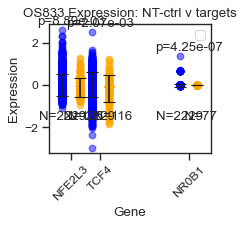

In [3]:
###  MUST REMOVE SCALING AND INCREASE THE NUMBER OF VARIABLE GENES USED TO 5-6K


valid_genes = [gene for gene in kd_counts.index if gene in adata.var_names]

p_values = []

# Iterate over each valid gene to plot
for i, gene in enumerate(valid_genes):
    adata_ctrl = adata[adata.obs['Gene'] == 'NT-ctrl']
    adata_gene = adata[adata.obs['Gene'] == gene]

    ctrl_expression = adata_ctrl[:, gene].X.flatten()
    gene_expression = adata_gene[:, gene].X.flatten()

    control_mean = np.mean(ctrl_expression)
    control_std = np.std(ctrl_expression)
    gene_mean = np.mean(gene_expression)
    gene_std = np.std(gene_expression)

    # Perform Welch's t-test
    t_stat, p_value = ttest_ind(ctrl_expression, gene_expression, equal_var=False)
    p_values.append(p_value)

# Adjust p-values for multiple comparisons using the Benjamini-Hochberg procedure
from statsmodels.stats.multitest import multipletests
rejections, corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')


# Assuming valid_genes and corrected_p_values are defined from previous steps
significance_threshold = 0.05

# Get the indices of significant genes for plotting purposes
significant_indices = [i for i, p_val in enumerate(corrected_p_values) if p_val < significance_threshold]


from scipy.stats import ttest_ind

plt.figure(figsize=(3, 3))

# Plot only significant genes
for i in significant_indices:
    # Indices and gene names correspond to significant genes only
    gene = valid_genes[i]
    adata_ctrl = adata[adata.obs['Gene'] == 'NT-ctrl']
    adata_gene = adata[adata.obs['Gene'] == gene]

    ctrl_expression = adata_ctrl[:, gene].X.flatten()
    gene_expression = adata_gene[:, gene].X.flatten()

    control_mean = np.mean(ctrl_expression)
    control_std = np.std(ctrl_expression)
    gene_mean = np.mean(gene_expression)
    gene_std = np.std(gene_expression)
    n_control = len(ctrl_expression)
    n_gene = len(gene_expression)

    # Perform Welch's t-test
    t_stat, p_value = ttest_ind(ctrl_expression, gene_expression, equal_var=False)

    # Create bars for the mean expression levels
    plt.bar(i - 0.3, control_mean, yerr=control_std, capsize=5, width=0.4, color='blue', label='NT-ctrl' if i == 0 else "")
    plt.bar(i + 0.3, gene_mean, yerr=gene_std, capsize=5, width=0.4, color='orange', label=gene if i == 0 else "")

    # Add individual data points
    plt.scatter([i - 0.3] * n_control, ctrl_expression, color='blue', alpha=0.5)
    plt.scatter([i + 0.3] * n_gene, gene_expression, color='orange', alpha=0.5)

    # Annotate the plot with p-values offset from the highest point in the plot
    y_offset = 0.1  # Adjust this value as needed to offset the p-value text
    max_expression = max(max(ctrl_expression), max(gene_expression))
    plt.text(i, max_expression + y_offset, f'p={p_value:.2e}', ha='center', va='bottom')
    

import matplotlib.pyplot as plt



# Add cell count information at the bottom of the plot
for i in significant_indices:
    gene = valid_genes[i]
    n_control = sum(adata.obs['Gene'] == 'NT-ctrl')
    n_gene = sum(adata.obs['Gene'] == gene)
    plt.text(i - 0.3, -1.2, f'N={n_control}', ha='center', va='top')
    plt.text(i + 0.3, -1.2, f'  N={n_gene}', ha='center', va='top')

# Set the x-ticks to correspond to significant genes only
plt.xticks(significant_indices, [valid_genes[i] for i in significant_indices], rotation=45)

# Set labels and title
plt.xlabel('Gene')
plt.ylabel('Expression')
plt.legend()
plt.title('OS833 Expression: NT-ctrl v targets')

# Adjust layout
plt.tight_layout()

# Save the plot as SVG
plt.savefig('/Users/brendamelano/Desktop/OS833_Target_Gene_KD_test.svg', format='svg')

plt.show()

# After saving, return the path to the saved SVG file
#plot_path = '/mnt/data/plot.svg'
#plot_path


# GSEA

computing score 'Subtype_B_score'
    finished: added
    'Subtype_B_score', score of gene set (adata.obs).
    242 total control genes are used. (0:00:00)


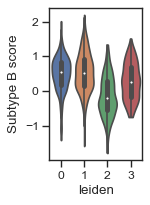

computing score 'Subtype_C_score'
    finished: added
    'Subtype_C_score', score of gene set (adata.obs).
    354 total control genes are used. (0:00:00)


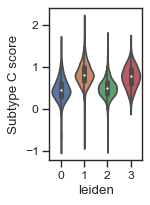

computing score 'Subtype_A_score'
    finished: added
    'Subtype_A_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'Subtype_B_score'
    finished: added
    'Subtype_B_score', score of gene set (adata.obs).
    242 total control genes are used. (0:00:00)
computing score 'Subtype_C_score'
    finished: added
    'Subtype_C_score', score of gene set (adata.obs).
    354 total control genes are used. (0:00:00)


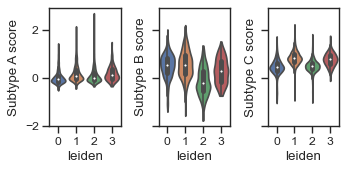

In [3]:
# reading in gene lists for gsea
Subtype_A_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_A_module.csv')]


adata.var_names_make_unique()


# keeping only genes that appear in the adata
Subtype_A_genes = [x for x in Subtype_A_genes if x in adata.var_names]



# reading in gene lists for gsea
subtype_B_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_B_module.csv')]


# keeping only genes that appear in the adata
subtype_B_genes = [x for x in subtype_B_genes if x in adata.var_names]


# Computing gsea
sc.tl.score_genes(adata, subtype_B_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_B_score', random_state=0, copy=False, use_raw=None)

# Plotting subtype B violin plot
sc.pl.violin(adata, ['Subtype_B_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel = 'Subtype B score')

# reading in gene lists for gsea
subtype_C_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_C_module.csv')]


adata.var_names_make_unique()


# keeping only genes that appear in the adata
subtype_C_genes = [x for x in subtype_C_genes if x in adata.var_names]


# Computing gsea
sc.tl.score_genes(adata, subtype_C_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_C_score', random_state=0, copy=False, use_raw=None)

sc.pl.violin(adata, ['Subtype_C_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel = 'Subtype C score')

genes_lists = [Subtype_A_genes, subtype_B_genes, subtype_C_genes]
score_names = ['Subtype_A_score', 'Subtype_B_score', 'Subtype_C_score']

# Making variable names unique
adata.var_names_make_unique()

# Compute GSEA scores and keep only genes present in 'adata'
for genes, score_name in zip(genes_lists, score_names):
    valid_genes = [gene for gene in genes if gene in adata.var_names]
    sc.tl.score_genes(adata, valid_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                      score_name=score_name, random_state=0, copy=False, use_raw=None)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(4.5, 2.3), sharey=True)

# Plotting each violin plot in a subplot
for i, score_name in enumerate(score_names):
    sc.pl.violin(adata, [score_name], groupby='leiden', stripplot=False, inner='box',
                 ylabel=score_name.replace('_', ' '), ax=axes[i], show=False)

# Adjust the layout
plt.tight_layout()

# Save the figure as an SVG file
plt.savefig('/Users/brendamelano/Desktop/OS742violin_plots.svg', format='svg')

# Chisquared analysis

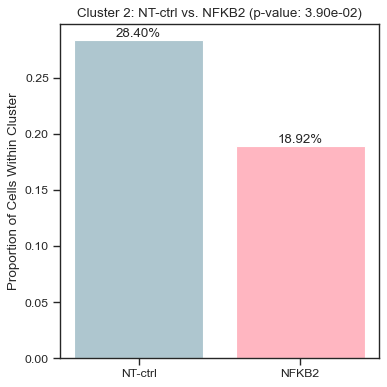

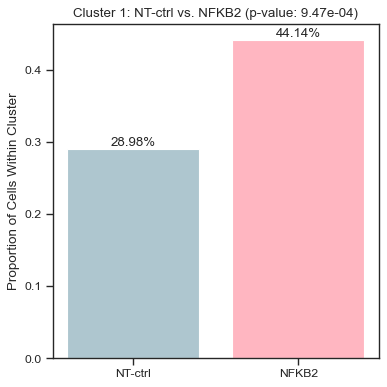

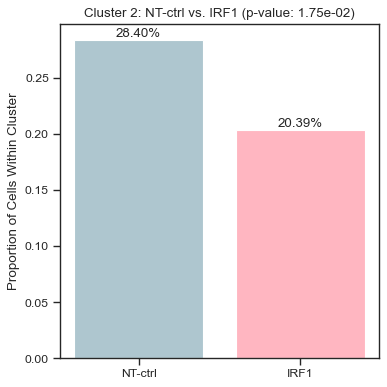

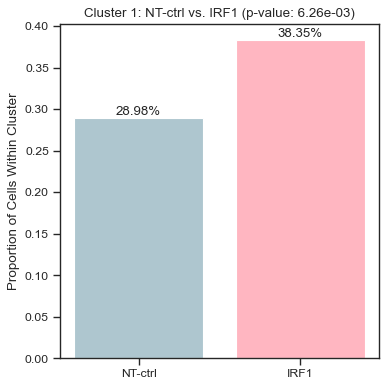

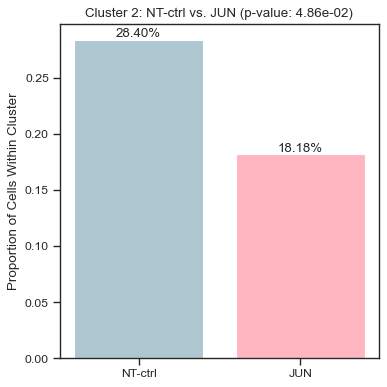

In [12]:
output_dir = "/Users/brendamelano/Desktop/"
os.makedirs(output_dir, exist_ok=True)

# Assuming adata is your AnnData object
significance_threshold = 0.05

# Unique genes excluding 'control'
unique_genes = adata.obs['Gene'].unique()
unique_genes = unique_genes[unique_genes != 'NT-ctrl']

# Iterate over each unique gene
for gene in unique_genes:
    # Iterate over each cluster
    for cluster in adata.obs['leiden'].unique():
        # Construct a contingency table
        contingency_table = pd.DataFrame(
            [
                [
                    ((adata.obs['Gene'] == gene) & (adata.obs['leiden'] == cluster)).sum(),
                    ((adata.obs['Gene'] == gene) & (adata.obs['leiden'] != cluster)).sum(),
                ],
                [
                    ((adata.obs['Gene'] == 'NT-ctrl') & (adata.obs['leiden'] == cluster)).sum(),
                    ((adata.obs['Gene'] == 'NT-ctrl') & (adata.obs['leiden'] != cluster)).sum(),
                ],
            ],
            index=[f"{gene}", "NT-ctrl"],
            columns=[f"In_Cluster_{cluster}", f"Outside_Cluster_{cluster}"]
        )

        # Adjust for zeros if necessary
        epsilon = 1e-10
        contingency_table += epsilon

        # Perform chi-squared test
        chi2, p, _, _ = chi2_contingency(contingency_table)
        is_significant = p < significance_threshold

        # Only plot if the result is significant
        if is_significant:
            # Cells for the gene of interest within and outside the cluster
            gene_in_cluster = ((adata.obs['Gene'] == gene) & (adata.obs['leiden'] == cluster)).sum()
            gene_total = (adata.obs['Gene'] == gene).sum()
            prop_gene_in_cluster = gene_in_cluster / gene_total

            # Cells for the control within and outside the cluster
            control_in_cluster = ((adata.obs['Gene'] == 'NT-ctrl') & (adata.obs['leiden'] == cluster)).sum()
            control_total = (adata.obs['Gene'] == 'NT-ctrl').sum()
            prop_control_in_cluster = control_in_cluster / control_total

            # Plotting
            categories = ['NT-ctrl', gene]
            proportions = [prop_control_in_cluster, prop_gene_in_cluster]
            plt.figure(figsize=(5, 5))
            bars = plt.bar(categories, proportions, color=['#aec6cf', '#ffb6c1'])

            plt.ylabel('Proportion of Cells Within Cluster')
            plt.title(f'Cluster {cluster}: NT-ctrl vs. {gene} (p-value: {p:.2e})')

            # Annotate bars with their respective percentages
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width() / 2., height, f'{height:.2%}', ha='center', va='bottom')

            # Use tight_layout() before saving
            plt.tight_layout()

            # Construct a unique filename for each plot
            filename = f"{gene}_vs_NT-ctrl_cluster_{cluster}.svg"
            filepath = os.path.join(output_dir, filename)

            # Save the plot as an SVG file
            plt.savefig(filepath, format='svg')

            # Optionally, display the plot
            plt.show()

            # Close the plot after saving and displaying to free memory and ensure the next plot is fresh
            plt.close()
            # Setup figure and axis manually

       

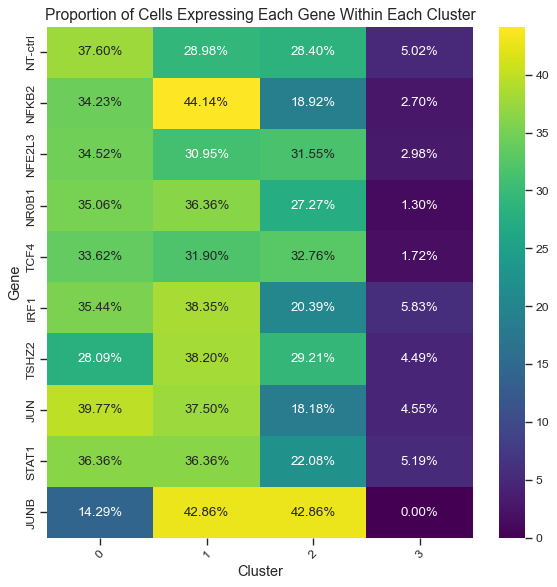

In [9]:
clusters_sorted = sorted(adata.obs['leiden'].unique())
gene_clusters = pd.DataFrame(columns=clusters_sorted)

# First, ensure 'NT-ctrl' is included at the beginning of the genes list
unique_genes = np.append('NT-ctrl', adata.obs['Gene'].unique())

# Fill the DataFrame
for gene in unique_genes:
    percentages = []
    gene_total = (adata.obs['Gene'] == gene).sum()  # Total cells expressing the gene across all clusters
    if gene_total == 0:  # Handle 'NT-ctrl' and any gene not found to avoid division by zero
        percentages = [0 for _ in clusters_sorted]
    else:
        for cluster in clusters_sorted:
            gene_in_cluster = ((adata.obs['Gene'] == gene) & (adata.obs['leiden'] == cluster)).sum()
            prop_gene_in_cluster = gene_in_cluster / gene_total  # Proportion of cells in this cluster for the gene
            percentages.append(prop_gene_in_cluster)
    gene_clusters.loc[gene] = percentages

# Convert to percentages
gene_clusters *= 100

# Convert each value to a string with a percentage sign for annotation
gene_clusters_str = gene_clusters.applymap(lambda x: "{:.2f}%".format(x))

# Plotting the heatmap
plt.figure(figsize=(7.5,7.5))
sns.heatmap(gene_clusters, annot=gene_clusters_str, fmt="s", cmap='viridis')
plt.title('Proportion of Cells Expressing Each Gene Within Each Cluster', fontsize=14)
plt.ylabel('Gene', fontsize=13)
plt.xlabel('Cluster', fontsize=13)
plt.xticks(rotation=45)
plt.tight_layout()

# Adjust the file path for saving the figure as needed
plt.savefig('/Users/brendamelano/Desktop/OS384_Percent_in_cluster_per_target.svg', format='svg')
plt.show()

# Visualizing cells from a certain target

In [16]:
adata.obs['TCF4'] = pd.Categorical(adata.obs['Gene'].apply(lambda x: 1 if x == 'TCF4' else 0))


adata = adata[adata.obs['TCF4'].sort_values(ascending=False).index]

# Define a custom color palette where 'False' is gray and 'True' is the default color (e.g., orange)
custom_palette = ['#808080', 'orange']  # gray for 'False', orange for 'True'

# Reorder data so that 'True' values are plotted last (on top)
adata_temp = adata[adata.obs['TCF4'].sort_values().index]
# Plot the UMAP with the custom color palette and increased dot size
sc.pl.umap(adata_temp, color='TCF4', palette=custom_palette, 
           add_outline=True, s=30, title='OS384 TCF4 perturbed cells')

# ,        save = "OS384_depleted_barcodes.svg"

# DGEA

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


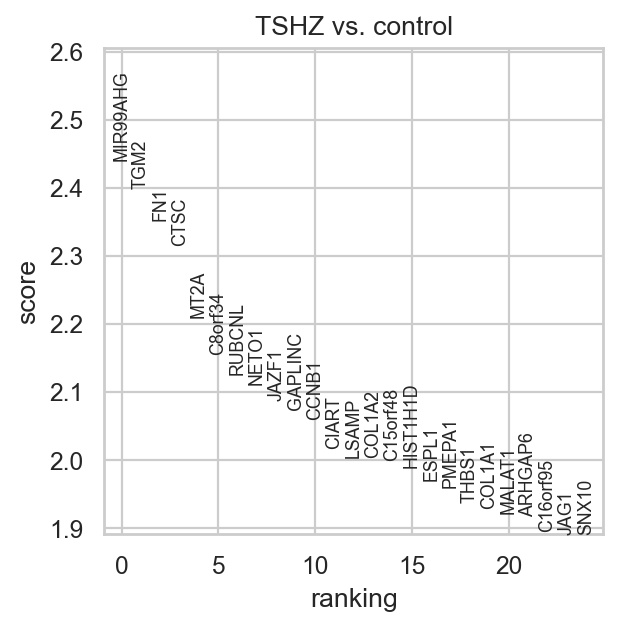

,Gene,Log2 fold change,P-value,Adjusted P-value
11,CIART,2.309402,0.045631,0.734283
5,C8orf34,2.257819,0.032906,0.734283
6,RUBCNL,2.244341,0.035295,0.734283
16,ESPL1,1.668098,0.050765,0.734283
0,MIR99AHG,1.601464,0.015869,0.639712
27,E2F8,1.562359,0.061149,0.734283
21,ARHGAP6,1.427774,0.057249,0.734283
24,SNX10,1.397857,0.060681,0.734283
23,JAG1,1.315577,0.060569,0.734283
9,GAPLINC,1.309699,0.039777,0.734283


In [22]:
adata_filtered = adata[adata.obs['Gene'].isin(['control', 'TSHZ'])].copy()

# Create a grouping variable
adata_filtered.obs['group'] = adata_filtered.obs['Gene']

# Perform differential gene expression analysis directly comparing 'control' vs 'TSHZ'
# You might want to specify reference as 'control' to compare 'TSHZ' against it
sc.tl.rank_genes_groups(adata_filtered, groupby='group', groups=['TSHZ'], reference='control')

# Access and visualize the results
sc.pl.rank_genes_groups(adata_filtered, n_genes=25)

# Access the differential expression results
results = adata_filtered.uns['rank_genes_groups']

# Extract the names, log fold changes, and p-values for the 'TSHZ' group
gene_names = results['names']['TSHZ'][:30]
logfoldchanges = results['logfoldchanges']['TSHZ'][:30]
pvals = results['pvals']['TSHZ'][:30]
pvals_adj = results['pvals_adj']['TSHZ'][:30]

# Create a DataFrame
df = pd.DataFrame({
    'Gene': gene_names,
    'Log2 fold change': logfoldchanges,
    'P-value': pvals,
    'Adjusted P-value': pvals_adj
})

df_sorted = df.sort_values(by='Log2 fold change', ascending=False)

df_sorted

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


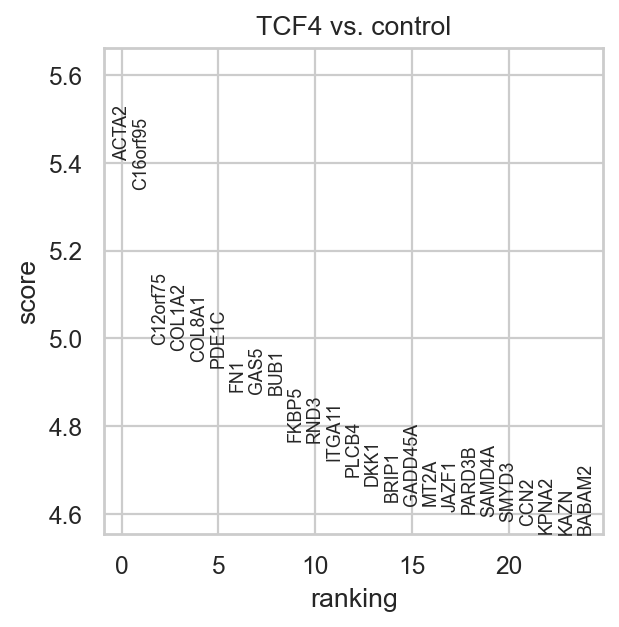

,Gene,Log2 fold change,P-value,Adjusted P-value
0,ACTA2,1.184418,1.431610e-07,0.000151
1,C16orf95,1.507022,2.007217e-07,0.000151
2,C12orf75,0.994539,1.111177e-06,0.000320
3,COL1A2,1.918139,1.238207e-06,0.000320
4,COL8A1,2.326457,1.417143e-06,0.000320
5,PDE1C,1.902020,1.482411e-06,0.000320
6,FN1,1.723759,1.886487e-06,0.000320
7,GAS5,1.031196,1.882272e-06,0.000320
8,BUB1,1.679735,1.919008e-06,0.000320
9,FKBP5,1.449650,3.188624e-06,0.000435


In [39]:
adata_filtered = adata[adata.obs['Gene'].isin(['control', 'TCF4'])].copy()

# Create a grouping variable
adata_filtered.obs['group'] = adata_filtered.obs['Gene']

# Perform differential gene expression analysis directly comparing 'control' vs 'TSHZ'
# You might want to specify reference as 'control' to compare 'TSHZ' against it
sc.tl.rank_genes_groups(adata_filtered, groupby='group', groups=['TCF4'], reference='control')

# Access and visualize the results
sc.pl.rank_genes_groups(adata_filtered, n_genes=25)

# Access the differential expression results
results = adata_filtered.uns['rank_genes_groups']

# Extract the names, log fold changes, and p-values for the 'TSHZ' group
gene_names = results['names']['TCF4'][:30]
logfoldchanges = results['logfoldchanges']['TCF4'][:30]
pvals = results['pvals']['TCF4'][:30]
pvals_adj = results['pvals_adj']['TCF4'][:30]

# Create a DataFrame
df = pd.DataFrame({
    'Gene': gene_names,
    'Log2 fold change': logfoldchanges,
    'P-value': pvals,
    'Adjusted P-value': pvals_adj
})

df

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


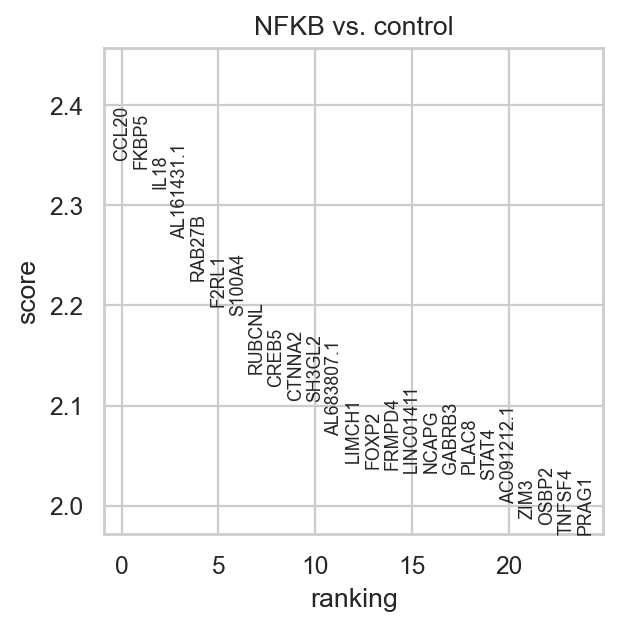

,Gene,Log2 fold change,P-value,Adjusted P-value
0,CCL20,2.611781,0.020669,0.66927
1,FKBP5,0.931622,0.021018,0.66927
2,IL18,1.695887,0.022141,0.66927
3,AL161431.1,1.649532,0.025139,0.66927
4,RAB27B,1.609588,0.027925,0.66927
5,F2RL1,2.313854,0.029861,0.66927
6,S100A4,0.693669,0.030209,0.66927
7,RUBCNL,2.181266,0.035029,0.66927
8,CREB5,1.362774,0.036067,0.66927
9,CTNNA2,2.058055,0.037346,0.66927


In [38]:
adata_filtered = adata[adata.obs['Gene'].isin(['control', 'NFKB'])].copy()

# Create a grouping variable
adata_filtered.obs['group'] = adata_filtered.obs['Gene']

# Perform differential gene expression analysis directly comparing 'control' vs 'TSHZ'
# You might want to specify reference as 'control' to compare 'TSHZ' against it
sc.tl.rank_genes_groups(adata_filtered, groupby='group', groups=['NFKB'], reference='control')

# Access and visualize the results
sc.pl.rank_genes_groups(adata_filtered, n_genes=25)

# Access the differential expression results
results = adata_filtered.uns['rank_genes_groups']

# Extract the names, log fold changes, and p-values for the 'TSHZ' group
gene_names = results['names']['NFKB'][:30]
logfoldchanges = results['logfoldchanges']['NFKB'][:30]
pvals = results['pvals']['NFKB'][:30]
pvals_adj = results['pvals_adj']['NFKB'][:30]

# Create a DataFrame
df = pd.DataFrame({
    'Gene': gene_names,
    'Log2 fold change': logfoldchanges,
    'P-value': pvals,
    'Adjusted P-value': pvals_adj
})

df

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


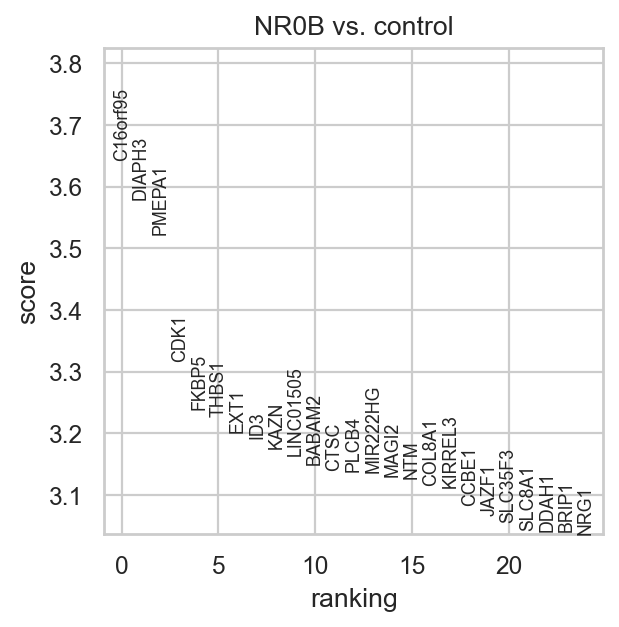

,Gene,Log2 fold change,P-value,Adjusted P-value
0,C16orf95,1.426125,0.000386,0.119439
1,DIAPH3,1.680651,0.000482,0.119439
2,PMEPA1,1.844014,0.000593,0.119439
3,CDK1,1.290546,0.001174,0.119439
4,FKBP5,1.420623,0.001532,0.119439
5,THBS1,1.677728,0.001582,0.119439
6,EXT1,1.682664,0.001716,0.119439
7,ID3,1.369741,0.001773,0.119439
8,KAZN,1.752926,0.001871,0.119439
9,LINC01505,1.859923,0.001942,0.119439


In [37]:
adata_filtered = adata[adata.obs['Gene'].isin(['control', 'NR0B'])].copy()

# Create a grouping variable
adata_filtered.obs['group'] = adata_filtered.obs['Gene']

# Perform differential gene expression analysis directly comparing 'control' vs 'TSHZ'
# You might want to specify reference as 'control' to compare 'TSHZ' against it
sc.tl.rank_genes_groups(adata_filtered, groupby='group', groups=['NR0B'], reference='control')

# Access and visualize the results
sc.pl.rank_genes_groups(adata_filtered, n_genes=25)

# Access the differential expression results
results = adata_filtered.uns['rank_genes_groups']

# Extract the names, log fold changes, and p-values for the 'TSHZ' group
gene_names = results['names']['NR0B'][:30]
logfoldchanges = results['logfoldchanges']['NR0B'][:30]
pvals = results['pvals']['NR0B'][:30]
pvals_adj = results['pvals_adj']['NR0B'][:30]

# Create a DataFrame
df = pd.DataFrame({
    'Gene': gene_names,
    'Log2 fold change': logfoldchanges,
    'P-value': pvals,
    'Adjusted P-value': pvals_adj
})

df

In [23]:
unique_genes = adata.obs['Gene'].unique().tolist()
non_control_genes = [gene for gene in unique_genes if gene != 'control']


In [25]:
# Read the CSV file into a DataFrame
Subtype_B = pd.read_csv('/Users/brendamelano/Desktop/gmt_files/Subtype_B_module.csv')

# If you need to convert the DataFrame column to a list (optional)
Subtype_B = Subtype_B['Gene'].tolist()

In [27]:
top_genes_per_comparison = []

In [31]:
group_counts = adata.obs['Gene'].value_counts()

# Filter out groups with only one sample
valid_groups = group_counts[group_counts > 1].index.tolist()

# Optionally, remove 'JUNB' explicitly if present
if 'JUNB' in valid_groups:
    valid_groups.remove('JUNB')

# Initialize the list to store top genes per comparison
top_genes_per_comparison = []

for target_gene in non_control_genes:
    # Check if the target_gene is in valid_groups before proceeding
    if target_gene in valid_groups:
        # Filter the data for 'control' and the current non-control gene
        adata_filtered = adata[adata.obs['Gene'].isin(['control', target_gene])].copy()
        adata_filtered.obs['group'] = adata_filtered.obs['Gene']

        # Perform differential gene expression analysis
        sc.tl.rank_genes_groups(adata_filtered, groupby='group', groups=[target_gene], reference='control')

        # Extract the top 40 genes
        results = adata_filtered.uns['rank_genes_groups']
        top_genes = results['names'][target_gene][:40]

        # Store the top 40 genes for this comparison
        top_genes_per_comparison.append((target_gene, top_genes.tolist()))
    else:
        print(f"Skipping {target_gene}: not enough samples or explicitly excluded.")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be i

In [32]:
top_genes_per_comparison

[('TSHZ',
  ['MIR99AHG',
   'TGM2',
   'FN1',
   'CTSC',
   'MT2A',
   'C8orf34',
   'RUBCNL',
   'NETO1',
   'JAZF1',
   'GAPLINC',
   'CCNB1',
   'CIART',
   'LSAMP',
   'COL1A2',
   'C15orf48',
   'HIST1H1D',
   'ESPL1',
   'PMEPA1',
   'THBS1',
   'COL1A1',
   'MALAT1',
   'ARHGAP6',
   'C16orf95',
   'JAG1',
   'SNX10',
   'NUF2',
   'WNT5B',
   'E2F8',
   'DDIT4',
   'HIST3H2A',
   'ZNF732',
   'ID1',
   'IFIT3',
   'RAP1GAP2',
   'PRC1',
   'ACTBL2',
   'BUB1',
   'FOS',
   'TP63',
   'COLEC12']),
 ('NFE2L3',
  ['COL8A1',
   'ZYG11A',
   'CTNNA2',
   'FKBP5',
   'ACTA2',
   'LINC01505',
   'IL1RAPL1',
   'AC073529.1',
   'AC026124.1',
   'ROBO2',
   'ADAMTS6',
   'DDAH1',
   'TBC1D4',
   'GPR39',
   'PAGE5',
   'NLGN1',
   'NEGR1',
   'NEAT1',
   'MIR222HG',
   'AC011246.1',
   'COL1A2',
   'BRIP1',
   'LINC01411',
   'KIRREL3',
   'PARD3B',
   'SLC8A1',
   'SLIT2',
   'IMMP2L',
   'PDE7B',
   'ST6GALNAC5',
   'HAPLN1',
   'CDH13',
   'FST',
   'MALAT1',
   'FN1',
   'PLCB4',
  

In [28]:
for target_gene in non_control_genes:
    # Filter the data for 'control' and the current non-control gene
    adata_filtered = adata[adata.obs['Gene'].isin(['control', target_gene])].copy()
    adata_filtered.obs['group'] = adata_filtered.obs['Gene']
    
    # Perform differential gene expression analysis
    sc.tl.rank_genes_groups(adata_filtered, groupby='group', groups=[target_gene], reference='control')
    
    # Extract the top 40 genes
    results = adata_filtered.uns['rank_genes_groups']
    top_genes = results['names'][target_gene][:40]
    
    # Store the top 40 genes for this comparison
    top_genes_per_comparison.append(top_genes.tolist())

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be i

ValueError: Could not calculate statistics for groups JUNB since they only contain one sample.

In [35]:
overlap_counts = []

# Assuming Subtype_B_module is a list of genes, convert it to a set for efficient lookup
Subtype_B_module_set = set(Subtype_B)

for i, (target_gene, gene_list) in enumerate(top_genes_per_comparison):
    # Convert gene_list to set for intersection operation, ensuring items are hashable (e.g., by converting to tuples if not already)
    gene_set = set(gene_list)  # This works if gene_list is a list of hashable items like strings
    overlap = len(gene_set & Subtype_B_module_set)
    overlap_counts.append((target_gene, overlap))

# Sort by overlap count to find the target gene with the highest overlap
overlap_counts.sort(key=lambda x: x[1], reverse=True)

# Now overlap_counts contains tuples of (target_gene, overlap_count) sorted by overlap count


In [36]:
overlap_counts

[('NFKB', 1),
 ('TCF4', 1),
 ('NR0B', 1),
 ('TSHZ', 0),
 ('NFE2L3', 0),
 ('STAT', 0),
 ('IRF', 0),
 ('JUN', 0),
 ('NFKB2', 0)]